In [1]:
# Importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score
from sklearn.utils import parallel_backend
from pyearth import Earth
from patsy import dmatrix
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
import warnings
from pyearth import Earth
from sklearn.model_selection import RandomizedSearchCV, KFold


In [2]:
# Loading data
X_test = pd.read_csv('data/X_test.csv')
X_train = pd.read_csv('data/X_train.csv')
y_test = pd.read_csv('data/y_test.csv')
y_train = pd.read_csv('data/y_train.csv')

### Coarse Grid Hyperparameter Optimization

In [14]:
# Coarse grid search for hyperparameter optimization
    # Note: I fit 25 models here and it took approximately an hour and a half (90 mins)

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = FutureWarning)

# Initializing optimal parameters & best score variables
opt_degree = 1
opt_max_terms = 500
best_score = -float('inf')

# Outer loop for degree
for degree in range(1, 11, 2):
    print('Fitting models for degree = ', degree)
    # Creating a MARS model with the current degree and max_terms
    model = Earth(max_terms = 500, max_degree = degree)
    
    # Inner loop for max_terms
    for terms in range(400, 1201, 200):
        print('     Fitting models for degree = ', degree, 'and max_terms = ', terms)
        # Setting the current max_terms
        model.max_terms = terms
        
        # 5-fold cross validation
        scores = cross_val_score(model,
                                 X_train,
                                 y_train, 
                                 cv = 5, 
                                 scoring = 'neg_mean_squared_error')
        
        # Computing mean score
        mean_score = scores.mean()
        
        # Checking if mean score is better than the current best score
        if mean_score > best_score:
            best_score = mean_score
            opt_degree = degree
            opt_max_terms = terms
            
# Training a new MARS model on the entire training set using the optimal parameters
model = Earth(max_terms = opt_max_terms, max_degree = opt_degree)
model.fit(X_train, y_train)

Fitting models for degree =  1
     Fitting models for degree =  1 and max_terms =  400
     Fitting models for degree =  1 and max_terms =  600
     Fitting models for degree =  1 and max_terms =  800
     Fitting models for degree =  1 and max_terms =  1000
     Fitting models for degree =  1 and max_terms =  1200
Fitting models for degree =  3
     Fitting models for degree =  3 and max_terms =  400
     Fitting models for degree =  3 and max_terms =  600
     Fitting models for degree =  3 and max_terms =  800
     Fitting models for degree =  3 and max_terms =  1000
     Fitting models for degree =  3 and max_terms =  1200
Fitting models for degree =  5
     Fitting models for degree =  5 and max_terms =  400
     Fitting models for degree =  5 and max_terms =  600
     Fitting models for degree =  5 and max_terms =  800
     Fitting models for degree =  5 and max_terms =  1000
     Fitting models for degree =  5 and max_terms =  1200
Fitting models for degree =  7
     Fitting mo

Earth(max_degree=5, max_terms=400)

In [15]:
print('Optimal degree in coarse grid search = ', opt_degree)
print('Optimal max_terms in coarse grid search = ', opt_max_terms)

Optimal degree in coarse grid search =  5
Optimal max_terms in coarse grid search =  400


In [17]:
# Defining the initial base model 
mars_init = Earth(max_terms = 400, max_degree = 5)
mars_init.fit(X_train, y_train)
print(mars_init.summary())

Earth Model
------------------------------------------------------------------------------------------------------------------------------
Basis Function                                                                                           Pruned  Coefficient  
------------------------------------------------------------------------------------------------------------------------------
(Intercept)                                                                                              No      9.45395      
h(alcohol-0.869565)                                                                                      No      -14.0118     
h(0.869565-alcohol)                                                                                      Yes     None         
volatile acidity                                                                                         No      -3.94577     
h(density-0.0213997)*h(0.869565-alcohol)                                                           

In [18]:
# Making predictions
pred = mars_init.predict(X_test)

# Rounding predictions to the nearest integer 
rounded_pred = [round(p) for p in pred]

In [24]:
print("Coarse Grid Tuning MARS Model Test RMSE:", np.sqrt(mean_squared_error(y_test, rounded_pred)))

Coarse Grid Tuning MARS Model Test RMSE: 1.5657389506359167


### Fine Grid Hyperparameter Optimization

In [27]:
# Finer grid search - Thinking that this will take around 64 minutes if I timed it right
    # 18 models here total (vs the 25 in the larger coarse grid search)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = FutureWarning)

# Initializing optimal parameters & best score variables
opt_degree = 1
opt_max_terms = 500
best_score = -float('inf')

# Outer loop for degree
for degree in range(4, 7): # Now focusing in around 4, 5, 6
    print('Fitting models for degree = ', degree)
    # Creating a MARS model with the current degree and max_terms
    model = Earth(max_terms = 500, max_degree = degree)
    
    # Inner loop for max_terms
    for terms in range(300, 601, 50): # Now looking from 300 to 600 in steps of 50
        print('     Fitting models for degree = ', degree, 'and max_terms = ', terms)
        # Setting the current max_terms
        model.max_terms = terms
        
        # 5-fold cross validation
        scores = cross_val_score(model,
                                 X_train,
                                 y_train, 
                                 cv = 5, 
                                 scoring = 'neg_mean_squared_error')
        
        # Computing mean score
        mean_score = scores.mean()
        
        # Checking if mean score is better than the current best score
        if mean_score > best_score:
            best_score = mean_score
            opt_degree = degree
            opt_max_terms = terms
            
print("Optimal degree in fine grid search = ", degree)
print("Optimal max_terms in fine grid search = ", terms)

Fitting models for degree =  4
     Fitting models for degree =  4 and max_terms =  300
     Fitting models for degree =  4 and max_terms =  350
     Fitting models for degree =  4 and max_terms =  400
     Fitting models for degree =  4 and max_terms =  450
     Fitting models for degree =  4 and max_terms =  500
     Fitting models for degree =  4 and max_terms =  550
     Fitting models for degree =  4 and max_terms =  600
Fitting models for degree =  5
     Fitting models for degree =  5 and max_terms =  300
     Fitting models for degree =  5 and max_terms =  350
     Fitting models for degree =  5 and max_terms =  400
     Fitting models for degree =  5 and max_terms =  450
     Fitting models for degree =  5 and max_terms =  500
     Fitting models for degree =  5 and max_terms =  550
     Fitting models for degree =  5 and max_terms =  600
Optimal degree in fine grid search =  5
Optimal max_terms in fine grid search =  600


In [30]:
# Defining the initial base model 
mars_model = Earth(max_terms = 600, max_degree = 5)
mars_model.fit(X_train, y_train)

Earth(max_degree=5, max_terms=600)

In [32]:
# Making predictions
pred_opt = mars_model.predict(X_test)

# Rounding predictions to the nearest integer 
rounded_pred_opt = [round(p) for p in pred_opt]

In [33]:
# Printing the test RMSE of the fine grid tuning model
print("Fine Grid Tuning MARS Model Test RMSE:", np.sqrt(mean_squared_error(y_test, rounded_pred_opt)))

Fine Grid Tuning MARS Model Test RMSE: 1.5657389506359167


In [49]:
print(rounded_pred_opt.index)
print(residuals)


RangeIndex(start=0, stop=1300, step=1)
      quality   0   1   2   3   4   5   6   7   8  ...  1290  1291  1292  \
0         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   
1         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   
2         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   
3         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   
4         NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   
...       ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   
1295      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   
1296      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   
1297      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   
1298      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   
1299      NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ...   NaN   NaN   NaN   

      1293  1294  1295  1296  1297  1298  1299  

### Plotting Residuals & Actual vs Predicted Values

In [56]:
# Converting rounded_pred_opt to a df
rounded_pred_opt = pd.Series(rounded_pred_opt, name='quality')
rounded_pred_opt = rounded_pred_opt.to_frame().rename(columns={'quality': 'quality'})


# Calculate residuals
residuals = y_test - rounded_pred_opt

AttributeError: 'Axes' object has no attribute 'savefig'

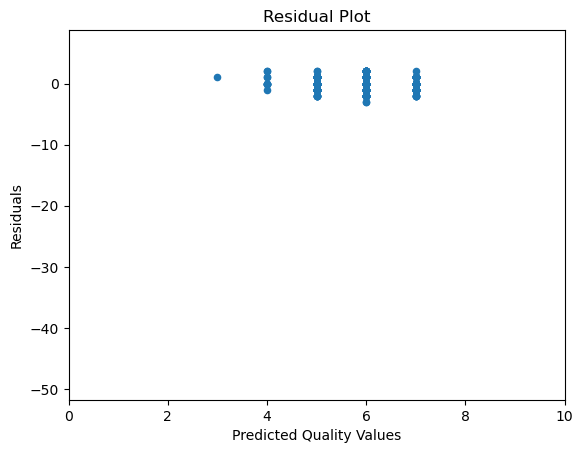

In [79]:
# Plotting residuals 
df = pd.concat([rounded_pred_opt, residuals], axis=1)
df.columns = ['quality', 'residuals']

residual_mars_plt = df.plot(x='quality', y='residuals', kind='scatter')
residual_mars_plt.set_xlabel('Predicted Quality Values')
residual_mars_plt.set_ylabel('Residuals')
residual_mars_plt.set_title('Residual Plot')
residual_mars_plt.set_xlim([0, 10])

# Saving the PNG
residual_mars_plt.savefig('residual_plot_MARS.png', dpi = 300)

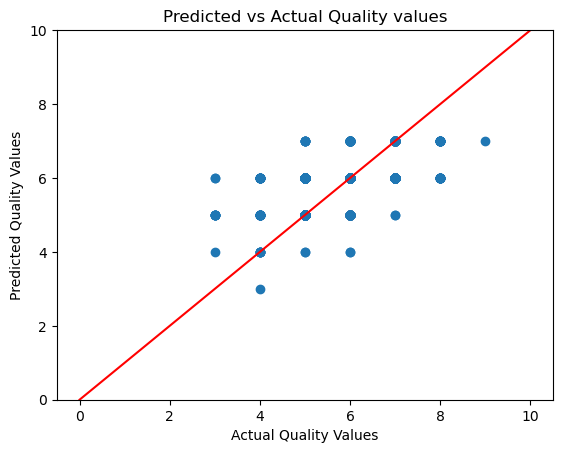

In [74]:
# Plotting predicted vs actual y values
plt.scatter(y_test, rounded_pred_opt)
plt.xlabel('Actual Quality Values')
plt.ylabel('Predicted Quality Values')
plt.title('Predicted vs Actual Quality values')
plt.ylim([0, 10])
plt.plot([0, 10], [0, 10], color='red')
plt.show()

### Creating a Model to Predict Residuals

In [71]:
# Fit a MARS model to predict residuals
residual_model = Earth()
residual_model.fit(rounded_pred_opt, residuals)

# Make predictions on test set
residuals_pred = residual_model.predict(rounded_pred_opt)

# Calculate overall RMSE of the residual model
residual_model_rmse = np.sqrt(mean_squared_error(residuals, residuals_pred))

print("RMSE of Residual Model: {:.2f}".format(residual_model_rmse))

RMSE of Residual Model: 0.75


### Finalizing the Model & Predictions

In [73]:
# Making predictions using the optimized MARS model and the residuals model as well
    # Optimized MARS model predictions held in 'rounded_pred_opt'

# Making predictions with the residuals model
residuals_pred_unrounded = residual_model.predict(rounded_pred_opt)

# Rounding predictions to the nearest integer 
residuals_pred = [round(p) for p in residuals_pred_unrounded]

# Add predicted residuals to y_pred to get final predictions
y_pred_final = rounded_pred_opt + residuals_pred

# Calculating the final MARS model RMSE 
print("Test RMSE of Fine Grid MARS Model & Residuals Model:", np.sqrt(mean_squared_error(y_test, y_pred_final)))

ValueError: Unable to coerce to Series, length must be 1: given 1300